In [1]:
"""
    Pro's
    1. Faster as no pretrained model is required
    2. More generic (also an con)
    
    Con's
    1. Will always detect some area even if the screen is not visible
    
    Overcoming Con's
    1. OCR can actually detect if the image cropped is valid or not.
    2. Also added an validation that the subject image should always be a 4 sided polygon
    
"""
import sys
print(sys.version)

3.10.5 (main, Jun  6 2022, 18:49:26) [GCC 12.1.0]


In [13]:
## install the packages

!pip3 install opencv-python
!pip3 install seaborn
!pip3 install tensorflow
!pip3 install keras_ocr

██████████████████  ████████
██████████████████  ████████
██████████████████  ████████
██████████████████  ████████
████████            ████████
████████  ████████  ████████
████████  ████████  ████████
████████  ████████  ████████
████████  ████████  ████████
████████  ████████  ████████
████████  ████████  ████████
████████  ████████  ████████
████████  ████████  ████████
████████  ████████  ████████
kunal@bablu 
OS: Manjaro Linux x86_64 
Host: HP Pavilion Laptop 15-cs2xxx 
Kernel: 5.15.50-1-MANJARO 
Uptime: 1 hour, 27 mins 
Shell: fish 3.4.1 
DE: Xfce 4.16 
CPU: Intel i5-8265U (8) @ 3.900GHz [40.0°C] 
GPU: NVIDIA GeForce MX250 
GPU: Intel WhiskeyLake-U GT2 [UHD Graphics 620] 
Memory: 6190MiB / 7837MiB 

                        
                        


Defaulting to user installation because normal site-packages is not writeable
██████████████████  ████████
██████████████████  ████████
██████████████████  ████████
██████████████████  ████████
████████            ████████
████████ 

██████████████████  ████████
██████████████████  ████████
██████████████████  ████████
██████████████████  ████████
████████            ████████
████████  ████████  ████████
████████  ████████  ████████
████████  ████████  ████████
████████  ████████  ████████
████████  ████████  ████████
████████  ████████  ████████
████████  ████████  ████████
████████  ████████  ████████
████████  ████████  ████████
kunal@bablu 
OS: Manjaro Linux x86_64 
Host: HP Pavilion Laptop 15-cs2xxx 
Kernel: 5.15.50-1-MANJARO 
Uptime: 1 hour, 28 mins 
Shell: fish 3.4.1 
DE: Xfce 4.16 
CPU: Intel i5-8265U (8) @ 3.900GHz [43.0°C] 
GPU: NVIDIA GeForce MX250 
GPU: Intel WhiskeyLake-U GT2 [UHD Graphics 620] 
Memory: 6184MiB / 7837MiB 

                        
                        


Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 kB 637.2 kB/s eta 0:00:00 eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 813.8/813.8 kB 4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.6/195.6 kB 2.9 MB/s eta 0:00:00m eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 3.3 MB/s eta 0:00:00m eta 0:00:010:00:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 3.4 MB/s eta 0:00:00m eta 0:00:010:01:01
  Created wheel for editdistance: filename=editdistance-0.6.0-cp310-cp310-linux_x86_64.whl size=249104 sha256=6069b80fa7b21f38f66d6bdbd2812227808af04a145498055dde3e0b42193934
  Stored in directory: /home/kunal/.cache/pip/wheels/d2/c2/60/295c59f8772b195d952c943f53ac4936e4ac59fc47a0030a1a
  Created wheel for validators: filename=validators-0.20.0-py3-none-any.whl size=19582 sha256=958d2e6659939d03a4b07ed04cc75918ce4eefcea080d559bac7632d252148db
  Stored in directory: /home/kunal/.cache/pip/wheels/f2/ed/dd/d3a556ad245ef9dc570c6bcd2f22886d17b0b408dd3bbb9ac3
Successfully built editdistance validators


In [15]:
##importing the pacakages

import cv2
import pandas
import seaborn
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
import keras_ocr 
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /home/kunal/.keras-ocr/craft_mlt_25k.h5


2022-07-08 11:23:57.587139: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 18874368 exceeds 10% of free system memory.


Looking for /home/kunal/.keras-ocr/crnn_kurapan.h5


In [31]:
def image_pre_processing(image_loc, fast = False):
    
    
    image = cv2.imread(image_loc)

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blur = cv2.medianBlur(gray, 5)

    sharpen_kernel = np.array([[-1,-1,-1], [-1,10,-1], [-1,-1,-1]])
    sharpen = cv2.filter2D(blur, -1, sharpen_kernel)

    # Threshold and morph close
    thresh = cv2.threshold(sharpen, 125, 255, cv2.THRESH_BINARY_INV)[1]
    # thresh = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 145, 0)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
    close = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=2)

    # Find contours and filter using threshold area
    cnts = cv2.findContours(close, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]



    M = 0
    contour = 0;

    min_area = 100000
    max_area = 1500000
    image_number = 0
    for c in cnts:
        area = cv2.contourArea(c)
        if (area > M):
            M = area
            contour = c
    #     if area > min_area and area < max_area:
    #         x,y,w,h = cv2.boundingRect(c)
    #         cv2.rectangle(image, (x, y), (x + w, y + h), (36,255,12), 2)
    #         image_number += 1


    x,y,w,h = cv2.boundingRect(contour)
    approx = cv2.approxPolyDP(contour, 0.05 * cv2.arcLength(contour, True), True)
    
    if (len(approx) != 4):
        print("UNABLE TO DETECT THIS...")
        plt.imshow(image)
#         return
    
    print(len(approx))
#     cv2.rectangle(image, (x, y), (x + w, y + h), (36,255,12), 2)

    if not fast:
        fig, ax = plt.subplots(figsize=(18, 15))

        plt.subplot(2,2,1)
        im = plt.imshow(sharpen, 'gray')

        plt.subplot(2,2,2)
        im = plt.imshow(close, 'gray')

        plt.subplot(2,2,3)
        im = plt.imshow(thresh, 'gray')

        plt.subplot(2,2,4)

        crop = image[y:y+h, x:x+w]  # This is ugly but works
        im = plt.imshow(crop)

        plt.show()
    
    else:
        fig, ax = plt.subplots(figsize=(10, 5))
        
        plt.subplot(1,2,1)
        im = plt.imshow(image)
        
        plt.subplot(1,2,2)
        crop = image[y:y+h, x:x+w]  # This is ugly but works
        im = plt.imshow(crop)
        
        plt.show()
    
#     crop = cv2.cvtColor(thresh, cv2.COLOR_GRAY2BGR)
    return crop

In [10]:
# dir_path=r"/home/kunal/GDC/care_ocr/dataset/additional/5-para"

dir_path=r"/home/kunal/GDC/care_ocr/dataset/"

image (4).png
4


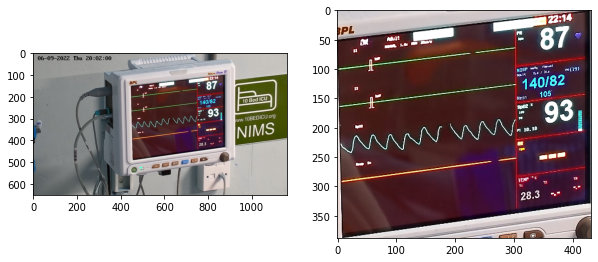

image (3).png
4


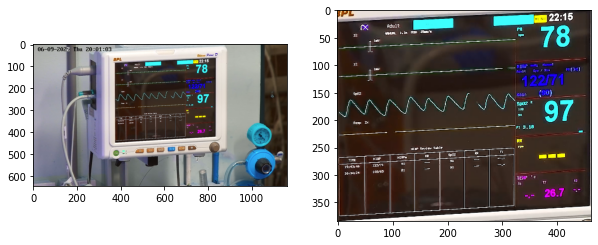

image (2).png
4


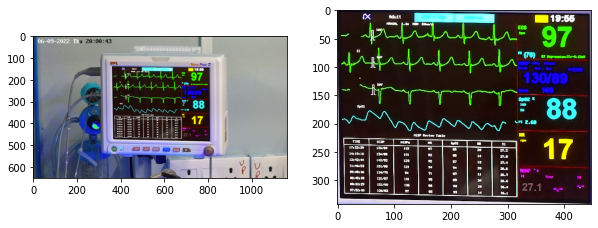

image (1).png
4


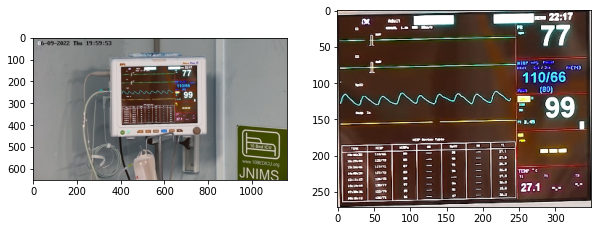

image.png
4


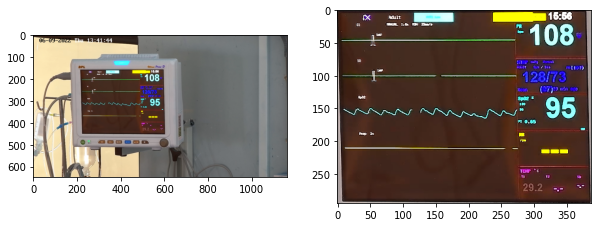

In [11]:
import os

for image in os.listdir(dir_path):
    if image[-3:] != 'jpg' and image[-3:] != "png":
          continue
    print(image)
    image_pre_processing(os.path.join(dir_path, image), True)

4


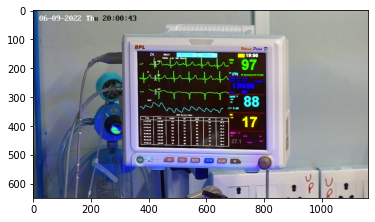

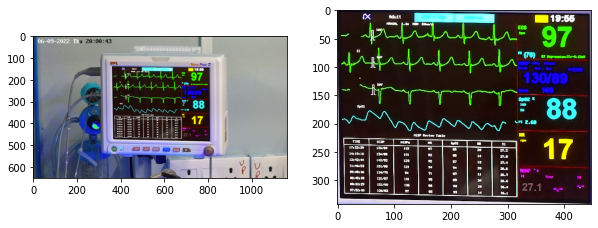

In [29]:
def ocr_part(img):
    # getting image column
    col = (img.shape[1]*70)//100

    crop_img = img[:, col:]
    plt.imshow(crop_img)
    
    prediction_groups = pipeline.recognize([img])

    print("-"*20)
    headings = ["Pulse Rate", "Blood Pressure", "SpO2", "Respiratory Rate", "Temperature"]
    counter = 0
    for text, box in prediction_groups[0]:
        if(counter == 5):
            break
        if(text.isnumeric() or "/" in text):
            if(counter == 1):
              text_1 = text[0:3]
              text_2 = text[4:]
              print(f"{headings[counter]}: {text_1}/{text_2}")
            elif(counter == 3 and len(text) == 3):
              print(f"{headings[counter]}: None")
              counter+=1
              # print temp
              text_1 = text[0:2]
              text_2 = text[2:]
              print(f"{headings[counter]}: {text_1}.{text_2}")
            elif(counter == 4):
              text_1 = text[0:2]
              text_2 = text[2:]
              print(f"{headings[counter]}: {text_1}.{text_2}")
            else:
              print(f"{headings[counter]}: {text}")
            counter+=1
    print("-"*20)

4


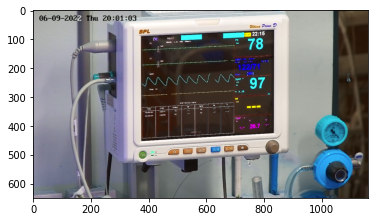

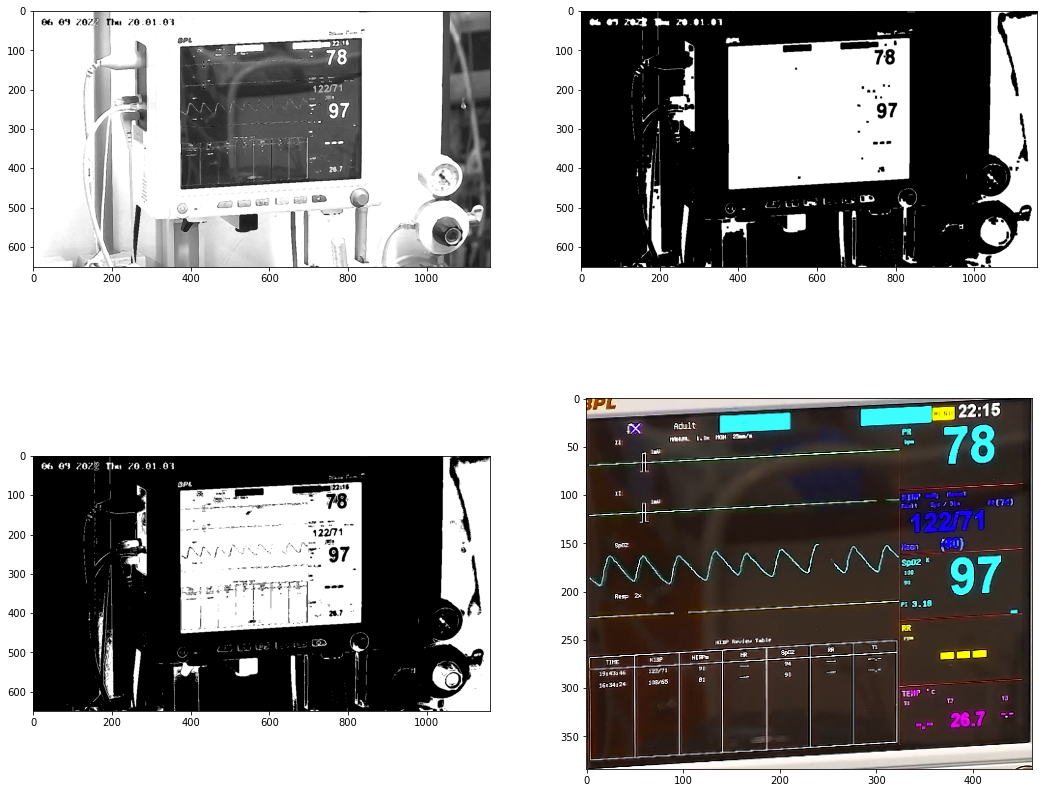

1/1 [==============================] - 2s 2s/step
--------------------
Pulse Rate: 2215
Blood Pressure: 78/
SpO2: 122470
Respiratory Rate: 97
Temperature: 51.0
--------------------


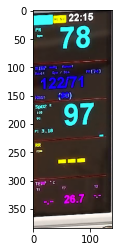

In [33]:
image_loc = "./dataset/image (3).png"
image = cv2.imread(image_loc)
plt.imshow(image)
cropped_image = image_pre_processing(image_loc)
ocr_part(cropped_image)